In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [0]:
# Ruta raiz
PATH = "/content/drive/My Drive/flowers"

# Ruta de datos de entrada
INPATH = PATH + "/inputFlowers"

# Ruta de datos de salida
OUTPATH = PATH + "/targetFlowers"

# Ruta checkpoints
CKPATH = PATH + "/checkpoints"

In [0]:
 # Esto me permite hacer una lista con los nombres de las imagenes
 
 imgurls = !ls -1 "{INPATH}"

 #imgurls

In [11]:
#n = 400 # n es la cantidad de imagenes de entrenamiento
n = 40
train_n = round(n * 0.80) # set de entrenamineto va a ser el 80% de n

# Listado randomizado, haciendo una copia del listado
randurls = np.copy(imgurls)

# mezclamos los filenames aleatoriamente
np.random.seed(23) # solo usamos una semilla para el tutorial, normalmente lo sacaria
np.random.shuffle(randurls)

# Particion train/test
tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:n]

print(len(imgurls), len(tr_urls), len(ts_urls))

7728 32 8


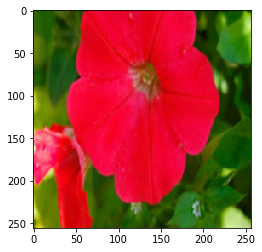

In [12]:
# Pre procesamiento de las imagenes

IMG_WIDTH = 256
IMG_HEIGHT = 256

#@tf.function
# Reescalar imagenes
def resize(inimg, tgimg, height, width):

  inimg = tf.image.resize(inimg, [height, width])
  tgimg = tf.image.resize(tgimg, [height, width])

  return inimg, tgimg


# Normaliza al rango [-1, 1] la imagen, ya que es mas facil de trabajar
def normalize(inimg, tgimg):

  inimg = (inimg / 127.5) - 1
  tgimg = (tgimg / 127.5) - 1

  return inimg, tgimg


# Aumentacion de datos : Random Crop + Flip
# Osea transformar, rotar, etc las imagenes para generar mas imagenes

def random_jitter(inimg, tgimg):

  inimg, tgimg = resize(inimg, tgimg, 286, 286) # aumentamos la dimension de las imagenes

  # luego hacemos desplzamientos aleatorios sobre las imagenes in y tg
  stacked_image = tf.stack([inimg, tgimg], axis=0) # apila las imagenes para que sean iguales
  cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3]) # hace los recortes aleatorios

  inimg, tgimg = cropped_image[0], cropped_image[1] # obtenemos devuelta las imagenes

  # un if aleatorio para voltear las imagenes
  #if tf.random.uniform(()) > 0.5:
  if np.random.random() > 0.5:

    inimg = tf.image.flip_left_right(inimg)
    tgimg = tf.image.flip_left_right(tgimg)

  return inimg, tgimg


# Carga de imagenes

def load_image(filename, augment=True):

  # Traigo la imagen desde el Drive, la traigo con la ayuda de tf.io.read_file, y luego las casteo a float
  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)), tf.float32)[..., :3] # limito los canales a RGB
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUTPATH + '/' + filename)), tf.float32)[..., :3]

  inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT, IMG_WIDTH)

  if augment:
    inimg, tgimg = random_jitter(inimg, tgimg)
  
  inimg, tgimg = normalize(inimg, tgimg)

  return inimg, tgimg


def load_train_image(filename):
  return load_image(filename, True)

def load_test_image(filename):
  return load_image(filename, False)


plt.imshow(((load_train_image(randurls[0])[1]) + 1) / 2)

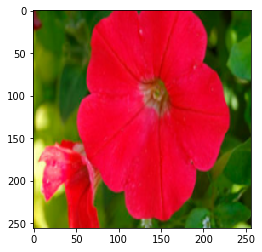

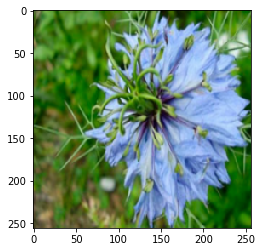

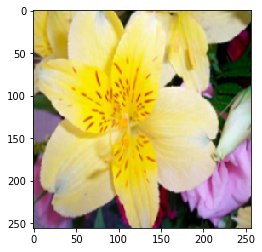

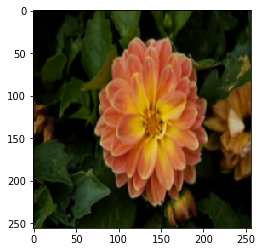

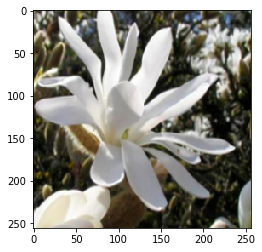

In [13]:
# Carga de datos

train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)

for inimg, tgimg in train_dataset.take(5):
  plt.imshow(((tgimg[0, ...]) + 1) / 2)
  plt.show()

In [0]:
# Diseño del modelo pix2pix

from tensorflow.keras import *
from tensorflow.keras.layers import *

In [15]:
def downsample(filters, apply_batchnorm=True):

  result = Sequential()

  initializer = tf.random_normal_initializer(0, 0.02)

  # Capa convolucional
  result.add(Conv2D(filters,
                    kernel_size=4,
                    strides=2,
                    padding="same",
                    kernel_initializer=initializer,
                    use_bias=not apply_batchnorm))

  # Capa de BatchNormalization
  if apply_batchnorm:
    result.add(BatchNormalization())

  # Capa de activacion
  result.add(LeakyReLU())

  return result


downsample(64)

In [16]:
def upsample(filters, apply_dropout=False):

  result = Sequential()

  initializer = tf.random_normal_initializer(0, 0.02)

  # Capa convolucional
  result.add(Conv2DTranspose(filters,
                             kernel_size=4,
                             strides=2,
                             padding="same",
                             kernel_initializer=initializer,
                             use_bias=False))

  # Capa de BatchNormalization
  result.add(BatchNormalization())

  # Capa de Dropout que desconecta aleatoriamente las capas
  if apply_dropout:
    result.add(Dropout(0.5))

  # Capa de activacion
  result.add(ReLU())

  return result


upsample(64)

![texto alternativo](https://miro.medium.com/max/1252/1*QvC1TPA69_Qc2Wx2O5XSJQ.png)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


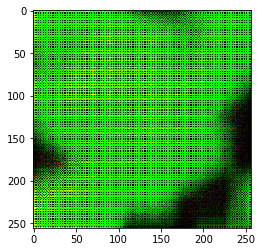

In [17]:
def Generator():

  inputs = tf.keras.layers.Input(shape=[None, None, 3])

  # Lista de bloques que van a conformar la red

  # encoder
  down_stack = [
                downsample(64, apply_batchnorm=False), # (bs, 128, 128, 64)      Dimensiones de las imagenes
                downsample(128),                       # (bs, 64,  64,  128)
                downsample(256),                       # (bs, 32,  32,  256)
                downsample(512),                       # (bs, 16,  16,  512)
                downsample(512),                       # (bs, 8,   8,   512)
                downsample(512),                       # (bs, 4,   4,   512)
                downsample(512),                       # (bs, 2,   2,   512)
                downsample(512),                       # (bs, 1,   1,   512)
  ]

  # decoder
  up_stack = [
              upsample(512, apply_dropout=True),       # (bs, 2,   2,   1024)
              upsample(512, apply_dropout=True),       # (bs, 4,   4,   1024)
              upsample(512, apply_dropout=True),       # (bs, 8,   8,   1024)
              upsample(512),                           # (bs, 16,  16,  1024)
              upsample(256),                           # (bs, 32,  32,  512)
              upsample(128),                           # (bs, 64,  43,  256)
              upsample(64),                            # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0, 0.02)

  # ultima capa
  last = Conv2DTranspose(filters=3,
                         kernel_size=4,
                         strides=2,
                         padding="same",
                         kernel_initializer=initializer,
                         activation="tanh")
  
  # Conexion de las capas estilo encode decoder para formar una u-net
  x = inputs
  s = []

  concat = Concatenate()

  # encoder
  for down in down_stack:
    x = down(x)
    s.append(x)

  s = reversed(s[:-1])

  # decoder
  for up, sk in zip(up_stack, s):
    x = up(x)
    x = concat([x, sk])

  last = last(x)

  return Model(inputs=inputs, outputs=last)


# Al estar instanciado aleatoriamente y no estar entrenado no genera nada coherente
generator = Generator()
gen_output = generator(((inimg+1)*255), training=False)
plt.imshow(gen_output[0, ...])

TensorShape([1, 16, 16, 1])

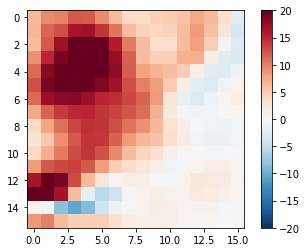

In [18]:
# Discriminador

def Discriminator():

  ini = Input(shape=[None, None, 3], name="input_img")
  gen = Input(shape=[None, None, 3], name="gener_img")

  con = concatenate([ini, gen])

  initializer = tf.random_normal_initializer(0, 0.02)

  down1 = downsample(64, apply_batchnorm=False)(con)
  down2 = downsample(128)(down1)
  down3 = downsample(256)(down2)
  down4 = downsample(512)(down3)

  last = tf.keras.layers.Conv2D(filters=1,
                                kernel_size=4,
                                strides=1,
                                kernel_initializer=initializer,
                                padding="same")(down4)
  
  return tf.keras.Model(inputs=[ini, gen], outputs=last)


# Probando el discriminador, azul poco realista
discriminator = Discriminator()
disc_output = discriminator([((inimg+1)*255), gen_output], training=False)
plt.imshow(disc_output[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()
disc_output.shape

In [0]:
# Funciones de costo

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(disc_real_output, disc_generated_output):

  # Diferencia entre los true por ser real y el detectado por el disciminador
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  # Diferencia entre los false por ser generado y el detectado por el discriminador
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [0]:
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):

  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

In [0]:
import os

# inizialiso los optimizadores como dice paper
generator_optimizer     = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Esto me permite ir guardando check points por si colab no me deja usar mas recursos
checkpoint_prefix = os.path.join(CKPATH, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# En esta linea restauro el modelo
#checkpoint.restore(tf.train.latest_checkpoint(CKPATH)).assert_consumed()

In [0]:
# Para ir evaluando como van las cosas durante el entrenamiento

def generate_images(model, test_input, tar, save_filename=False, display_imgs=True):

  prediction = model(test_input, training=True)

  if save_filename:
    tf.keras.preprocessing.image.save_img(PATH + '/outputA/' + save_filename + '.jpg', prediction[0, ...])

  plt.figure(figsize=(10,10))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input image', 'Ground Truth', 'Predicted Image']

  if display_imgs:

    for i in range(3):

      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      # getting the pixel values between [0, 1] to plot it
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')

  plt.show()

In [0]:
@tf.function()
def train_step(input_image, target):

  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:

    output_image = generator(input_image, training=True)

    output_gen_discr = discriminator([output_image, input_image], training=True)
    output_trg_discr = discriminator([target, input_image], training=True)

    discr_loss = discriminator_loss(output_trg_discr, output_gen_discr)
    gen_loss = generator_loss(output_gen_discr, output_image, target)


    generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_grads = discr_tape.gradient(discr_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))



In [0]:
from IPython.display import clear_output

def train(dataset, epochs):

  for epoch in range(epochs):
    imgi = 0

    for input_image, target in dataset:
      #print('epoch ' + str(epoch) + ' - train: ' + str(imgi) + '/' + str(len(tr_urls)))
      imgi += 1
      train_step(input_image, target)
    
    #clear_output(wait=True)

    imgi = 0
    for inp, tar in test_dataset.take(5):
      print('epoch ' + str(epoch) + ' - train: ' + str(imgi) + '/' + str(len(tr_urls)))
      generate_images(generator, inp, tar, str(imgi) + '_' + str(epoch), display_imgs=True)
      imgi += 1
    
    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 50 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [0]:
# 600 epochs da resultados realistas
train(train_dataset, 100) 